# Programming for Data Science and Artificial Intelligence

## Deep Learning -  NLP + TorchText

Let's work on sentiment analysis on some real dataset this time on IMDb reviews.  Also, let's learn about a useful torchtext library which is a library for handling text (aside from gensim, nltk, etc.).  Last, let's do word level input instead of character input.

In [1]:
import torchtext
import torch
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


### Loading the dataset

In [2]:
#uncomment this if you are not using puffer
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

from torchtext.datasets import IMDB
train_iter, test_iter = IMDB(split=('train', 'test'))

In [3]:
len(train_iter) + len(test_iter)

50000

In [4]:
#let's try print one train sample
next(train_iter)

('neg',
 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

### Tokenizing

The first step is to decide which tokenizer we want to use, which depicts how we split our sentences.

In [5]:
#pip install spacy
#python -m spacy download en_core_web_sm
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokens = tokenizer("We are learning torchtext in U.K.!")  #some test
tokens

['We', 'are', 'learning', 'torchtext', 'in', 'U.K.', '!']

### Text to integers

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [6]:
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab["<unk>"])

In [7]:
#see some example
vocab(['here', 'is', 'a', 'unknownword', 'a'])

[164, 11, 8, 0, 8]

In [8]:
len(vocab)

121068

### Defining hyperparameters

In [9]:
input_dim = len(vocab)
hidden_dim = 256
embed_dim = 100
output_dim = 1

#training hyperparameters
batch_size = 64
num_epochs=5
lr=1e-3

### Batch Iterator

In torchtext, first thing before the batch iterator is to define how you want to process your text and label.  

In [10]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == 'pos' else 0

In [11]:
len(train_iter)

25000

Next, let's make the batch iterator.  Here we create a function <code>collate_fn</code> that define how we want to create our batch.  Here, in our function, we process the raw text data, and also add padding dynamicaly to match the longest sentences.

In [12]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    #criterion expects float labels
    return torch.tensor(label_list, dtype=torch.float64), pad_sequence(text_list, batch_first=True)

In [13]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

train_iter, test_iter = IMDB()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_loader = DataLoader(split_train_, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(split_valid_, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

In [14]:
print(next(iter(train_loader)))

(tensor([1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
        0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 1., 0.], dtype=torch.float64), tensor([[  68,   11,    8,  ...,    0,    0,    0],
        [ 157,   17,   35,  ...,    0,    0,    0],
        [ 148,  148,  148,  ...,    0,    0,    0],
        ...,
        [  68,   11,    8,  ...,    0,    0,    0],
        [7543,   11,    8,  ...,    0,    0,    0],
        [  13, 3577,   10,  ...,    0,    0,    0]]))


In [15]:
vocab.lookup_tokens([13, 1662, 13, 16140, 73275, 19, 37976, 48, 85, 422])

['I', 'wall', 'I', '1914', 'Celebration', '-', 'Z.I.T.', 'from', 'my', 'video']

In [16]:
label, text = next(iter(train_loader))
print("Label shape: ", label.shape) # (batch_size, )
print("Text shape: ", text.shape) # (batch_size, seq len)

Label shape:  torch.Size([64])
Text shape:  torch.Size([64, 878])


In [17]:
label, text = next(iter(train_loader))
print("Label shape: ", label.shape) # (batch_size, )
print("Text shape: ", text.shape) # (batch_size, seq len)

Label shape:  torch.Size([64])
Text shape:  torch.Size([64, 1040])


### Build the Model

Within the `__init__` we define the _layers_ of the module. Our three layers are an _embedding_ layer, our RNN, and a _linear_ layer.

Our RNN takes in sequence of words, $X=\{x_1, ..., x_T\}$, one at a time, and produces a _hidden state_, $h$, for each word. We use the RNN _recurrently_ by feeding in the current word $x_t$ as well as the hidden state from the previous word, $h_{t-1}$, to produce the next hidden state, $h_t$. 

$$h_t = \text{RNN}(x_t, h_{t-1})$$

Once we have our final hidden state, $h_T$, (from feeding in the last word in the sequence, $x_T$) we feed it through a linear layer, $f$, (also known as a fully connected layer), to receive our predicted sentiment, $\hat{y} = f(h_T)$.

Below shows an example sentence, with the RNN predicting zero, which indicates a negative sentiment. The RNN is shown in orange and the linear layer shown in silver. Note that we use the same RNN for every word, i.e. it has the same parameters. The initial hidden state, $h_0$, is a tensor initialized to all zeros. 

<img src = "../figures/sentiment1.png" width="300">

The embedding layer is used to transform our integer into a vector.  Here we gonna create one vector sized 200 for one integer.  Thus the embedding layer shall be <code>nn.Embedding(len(vocab), 200)</code>

In [18]:
embedding = nn.Embedding(10, 3)
x = torch.LongTensor([[1,2,4,5],[4,3,2,9]]) #must be long
print(x.shape) # (sent len, batch)
embedded_x = embedding(x)
print(embedded_x.shape)
print(embedded_x)

torch.Size([2, 4])
torch.Size([2, 4, 3])
tensor([[[-0.1066,  0.0626, -0.4598],
         [-0.0385, -0.9721,  1.5405],
         [-0.9490, -0.6491,  0.8059],
         [-1.1712,  0.3129,  0.4264]],

        [[-0.9490, -0.6491,  0.8059],
         [-0.3739, -0.1505,  0.9182],
         [-0.0385, -0.9721,  1.5405],
         [ 0.2974,  0.4814,  1.5693]]], grad_fn=<EmbeddingBackward>)


The RNN returns 2 tensors, `output` of size _**[sentence length, batch size, hidden dim]**_ and `hidden` of size _**[1, batch size, hidden dim]**_. `output` is the concatenation of the hidden state from every time step, whereas `hidden` is simply the final hidden state. We verify this using the `assert` statement. Note the `squeeze` method, which is used to remove a dimension of size 1. 

Finally, we feed the last hidden state, `hidden`, through the linear layer, `fc`, to produce a prediction.

In [19]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        #text = [batch size, seq len]
        embedded = self.embedding(text)
        
        #embedded = [batch size, seq len, embed dim]
        output, hn = self.rnn(embedded)  #if no h0, all zeroes
        
        #output = [batch size, seq len, hidden dim]
        #hidden = [1, batch size, hidden dim]
        
        assert torch.equal(output[:,-1,:], hn.squeeze(0))
        return self.fc(hn.squeeze(0))

In [20]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)

In [21]:
w = torch.empty(3, 5)
nn.init.xavier_normal_(w)

tensor([[-0.4117,  0.5875, -0.0631, -0.0093,  0.4139],
        [ 0.4249, -0.4263, -0.3662,  0.5007,  0.3467],
        [-0.3409, -0.0963, -0.4063, -0.7413,  0.9737]])

In [22]:
model = RNN().to(device)
model.apply(initialize_weights)

RNN(
  (embedding): Embedding(121068, 100)
  (rnn): RNN(100, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [23]:
#we can print the complexity by the number of parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

12198705


### Training

In [24]:
import torch.optim as optim

#training hyperparameters
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss() #combine sigmoid with binary cross entropy

In [25]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [26]:
def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i, (label, text) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc = binary_accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [27]:
def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text = text.to(device) #(sent len, batch_size)

            predictions = model(text).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

### Putting everything together

In [28]:
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/intro_torchtext.pt')
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 0.695 | Train Acc: 50.04%
	 Val. Loss: 0.692 |  Val. Acc: 51.66%
Epoch: 02 | Train Loss: 0.695 | Train Acc: 49.99%
	 Val. Loss: 0.694 |  Val. Acc: 48.76%
Epoch: 03 | Train Loss: 0.695 | Train Acc: 49.77%
	 Val. Loss: 0.692 |  Val. Acc: 48.91%
Epoch: 04 | Train Loss: 0.694 | Train Acc: 50.23%
	 Val. Loss: 0.696 |  Val. Acc: 49.12%
Epoch: 05 | Train Loss: 0.695 | Train Acc: 50.28%
	 Val. Loss: 0.699 |  Val. Acc: 48.74%


Text(0, 0.5, 'loss')

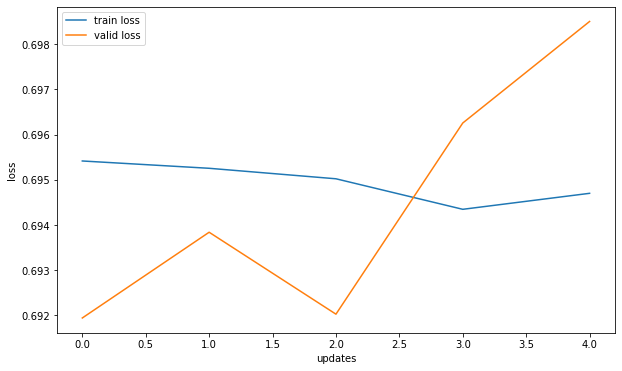

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

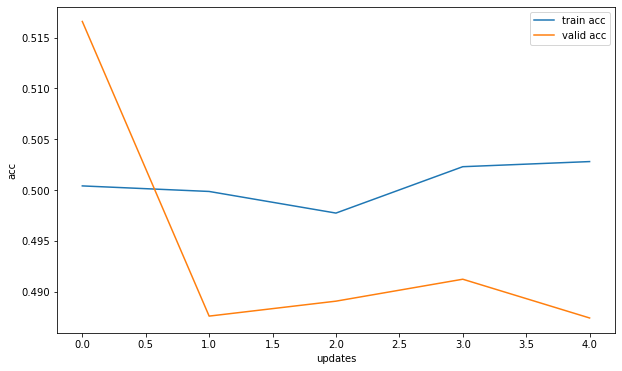

In [30]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [31]:
model.load_state_dict(torch.load('models/intro_torchtext.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.695 | Test Acc: 50.04%


### Test on some random reviews

In [32]:
test_str = "This is Chaky.  This movie is really bad bad bad."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([ 68,  11,   0,   6,   0,  68,  24,  11,  79, 102, 102, 102,   6],
       device='cuda:0')

In [33]:
vocab.lookup_tokens([ 68,  11,   0,   6,   0,  68,  24,  11,  79, 102, 102, 102,   6])

['This',
 'is',
 '<unk>',
 '.',
 '<unk>',
 'This',
 'movie',
 'is',
 'really',
 'bad',
 'bad',
 'bad',
 '.']

In [34]:
text = text.reshape(1, -1)  #because batch_size is 1

In [35]:
text.shape

torch.Size([1, 13])

In [36]:
def predict(text, text_pipeline):
    with torch.no_grad():
        output = model(text).squeeze(1)
        rounded_preds = torch.round(torch.sigmoid(output))
        return rounded_preds

In [37]:
predict(text, text_pipeline)  #not accurate!!!

tensor([1.], device='cuda:0')